# Dimensionality Reduction and Clustering of EEG DMD Features
This notebook demonstrates the workflow for reducing the dimensionality of DMD feature arrays extracted from EEG data, clustering patients, and evaluating the relationship between clusters and treatment response.

## 1. Import Required Libraries
Import all necessary libraries for data handling, dimensionality reduction, clustering, and visualization.

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import sys
sys.path.append('..')
from complexitylib import Patient
warnings.filterwarnings("ignore", category=UserWarning)

## 2. Load and Process DMD Arrays
Load the DMD feature arrays for each patient from CSV files and create a list of Patient objects.

In [13]:
# Define the folder containing the CSV files
input_folder = '../output/raw'
arrays = []
count = 0
patients = []
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        if 'S1' in filename:  # Only use first session (pre-treatment)
            filepath = os.path.join(input_folder, filename)
            array = np.loadtxt(filepath, delimiter=',')
            arrays.append(array)
            name = filename[:4]
            patients.append(Patient(id=count, name=name, DMDbefore=array))
            count += 1

## 3. Flatten and Reduce Dimensionality
Flatten each 2D DMD array into a 1D vector and use PCA to reduce dimensionality while retaining most of the variance.

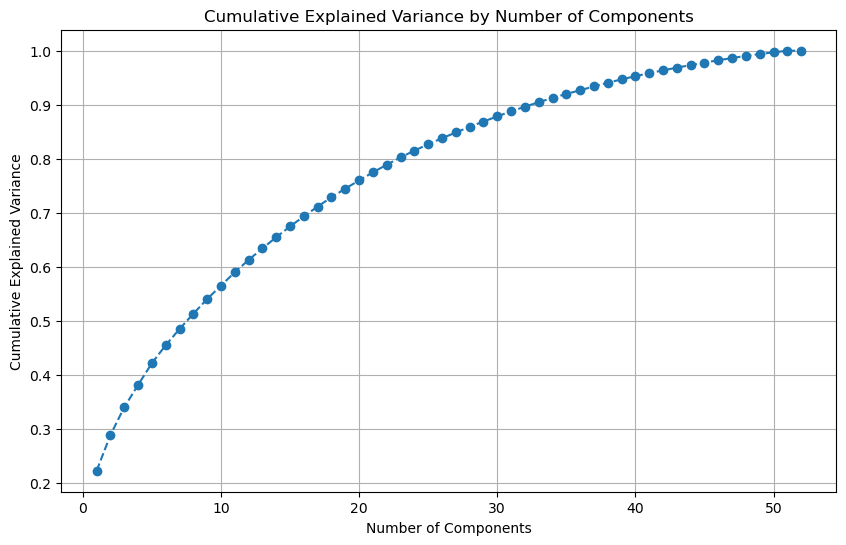

Number of components to retain 95.0% variance: 40


In [14]:
# Flatten each 2D array into a 1D array
flattened_arrays = [array.flatten() for array in arrays]

# Reduce dimensionality using PCA (initially keep all components)
pca = PCA()
reduced_data = pca.fit_transform(flattened_arrays)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance to select the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Set a threshold (e.g., 95%) and find the number of components to retain
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components to retain {threshold*100}% variance: {num_components}")

# Redo PCA with optimal number of components
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(flattened_arrays)

## 4. Clustering with K-Means
Cluster the patients based on their reduced DMD features using the k-means algorithm. Use the elbow method to select the optimal number of clusters.

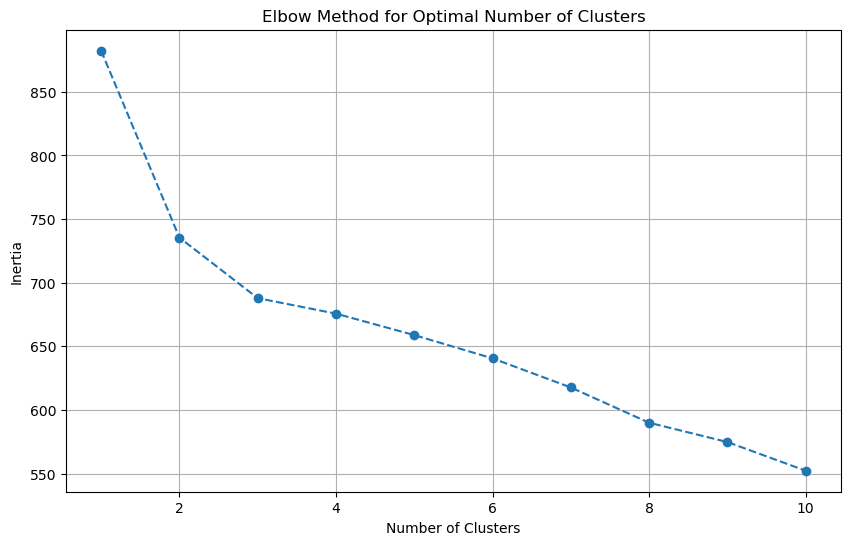

Patient DD01 is in cluster 0
Patient DD02 is in cluster 0
Patient DD03 is in cluster 2
Patient DD04 is in cluster 1
Patient DD05 is in cluster 1
Patient DD06 is in cluster 0
Patient DD07 is in cluster 1
Patient DD08 is in cluster 0
Patient DD09 is in cluster 2
Patient DD11 is in cluster 1


In [15]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Choose the number of clusters (e.g., 3 based on the elbow)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Assign cluster labels to each patient
for pat in patients:
    pat.cluster = clusters[pat.id]

# Print cluster assignment for the first 10 patients
for pat in patients[:10]:
    print(f"Patient {pat.name} is in cluster {pat.cluster}")

## 5. Visualize Clusters with t-SNE
Use t-SNE to visualize the clustering of patients in two dimensions.

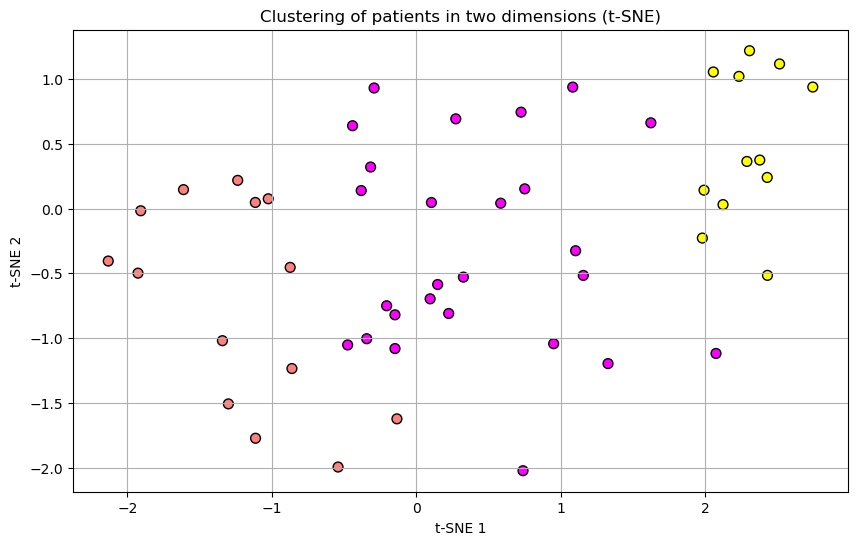

In [16]:
from sklearn.manifold import TSNE
# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(reduced_data))

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=clusters, cmap='spring', marker='o', edgecolor='k', s=50)
plt.title('Clustering of patients in two dimensions (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid()
plt.show()

## 6. Map Clusters to Treatment Response
Load clinical data and map cluster assignments to treatment response and depression type for each patient.

In [17]:
# Load clinical data
file_path = '../datasets/antidepressant-study/DD_Demographics.csv'
df = pd.read_csv(file_path)

# Map response and depression type to each patient
for pat in patients:
    row = df[df['ID'] == pat.name]
    if not row.empty:
        responder = row.iloc[0]['Responders']
        if responder == 'Responders':
            pat.response = True
        elif responder == 'Non-responders':
            pat.response = False
        else:
            pat.response = None
            print(f"Unknown response for patient {pat.name}: {responder}")
        depression_type = row.iloc[0]['MDD Type']
        pat.depression_type = depression_type
    else:
        print(f"Patient {pat.name} not found in DataFrame.")

Unknown response for patient DD19: nan
Unknown response for patient DD23: nan


## 7. Prepare Data for Predictive Modeling
Remove patients with missing response data and prepare features for classification.

In [18]:
# Remove patients with missing response data
patients_resp = [p for p in patients if p.name not in ['DD19', 'DD23']]
print([p.name for p in patients_resp])
print(f"Number of patients for prediction: {len(patients_resp)}")

['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06', 'DD07', 'DD08', 'DD09', 'DD11', 'DD12', 'DD13', 'DD14', 'DD15', 'DD16', 'DD17', 'DD18', 'DD20', 'DD21', 'DD22', 'DD24', 'DD25', 'DD26', 'DD27', 'DD28', 'DD29', 'DD30', 'DD31', 'DD32', 'DD33', 'DD34', 'DD35', 'DD36', 'DD37', 'DD38', 'DD39', 'DD40', 'DD41', 'DD42', 'DD43', 'DD44', 'DD45', 'DD46', 'DD47', 'DD48', 'DD49', 'DD50', 'DD51', 'DD52', 'DD53']
Number of patients for prediction: 50


## 8. Predicting Treatment Response
Test the predictive ability of clusters and DMD features using a Random Forest classifier. Compare three models: (1) clusters + DMD, (2) clusters only, (3) DMD only.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Model 1: Clusters and DMD arrays as features

Baseline Accuracy (Majority Class): 0.52
Model Accuracy: 0.60

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.33      0.50         9
        True       0.50      1.00      0.67         6

    accuracy                           0.60        15
   macro avg       0.75      0.67      0.58        15
weighted avg       0.80      0.60      0.57        15



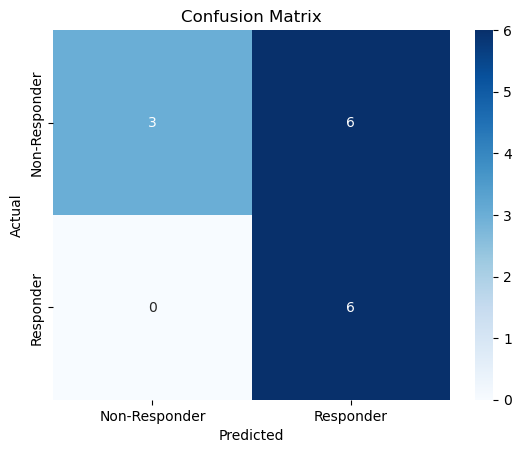

In [20]:
# Prepare the data
# Cluster labels as features
cluster_df = pd.DataFrame({
        'clusters': [pat.cluster for pat in patients_resp]
    })

cluster_encoded = pd.get_dummies(cluster_df, columns=['clusters'])  # One-hot encoding for categorical features
X_baseline = pd.DataFrame([pat.DMDbefore.flatten() for pat in patients_resp])  # Flattened EEG data
X = pd.concat([cluster_encoded, X_baseline], axis=1) # Combine features
X.columns = X.columns.astype(str) # Convert column names to string

y = np.array([pat.response for pat in patients_resp])  # Treatment response as target


# Define the baseline (majority class)
majority_class = np.argmax(np.bincount(y.astype(int)))
baseline_accuracy = np.mean(y == majority_class)
print(f"Baseline Accuracy (Majority Class): {baseline_accuracy:.2f}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
clus_dmd_test = y_test
clus_dmd_pred = y_pred



# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Responder', 'Responder'], yticklabels=['Non-Responder', 'Responder'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model 2: Only clusters as features

Baseline Accuracy (Majority Class): 0.52
Model Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.44      0.62         9
        True       0.55      1.00      0.71         6

    accuracy                           0.67        15
   macro avg       0.77      0.72      0.66        15
weighted avg       0.82      0.67      0.65        15



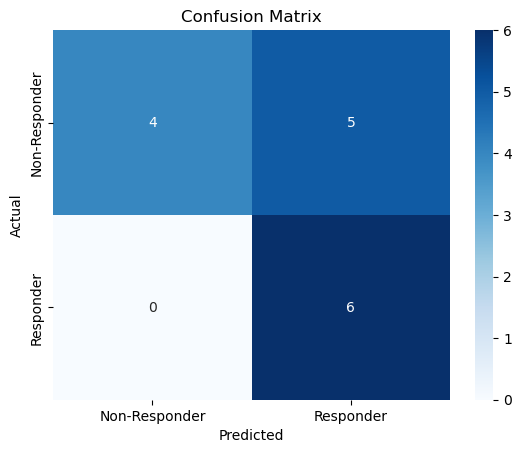

In [21]:
# Prepare the data
# Cluster labels as features
cluster_df = pd.DataFrame({
        'clusters': [pat.cluster for pat in patients_resp]
    })

X = pd.get_dummies(cluster_df, columns=['clusters'])  # One-hot encoding for categorical features
y = np.array([pat.response for pat in patients_resp])  # Treatment response as target


# Define the baseline (majority class)
majority_class = np.argmax(np.bincount(y.astype(int)))
baseline_accuracy = np.mean(y == majority_class)
print(f"Baseline Accuracy (Majority Class): {baseline_accuracy:.2f}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

clus_test = y_test
clus_pred = y_pred
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Responder', 'Responder'], yticklabels=['Non-Responder', 'Responder'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model 3: Only DMD arrays as features

Baseline Model Accuracy (Without Clusters): 0.60
Model Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.33      0.50         9
        True       0.50      1.00      0.67         6

    accuracy                           0.60        15
   macro avg       0.75      0.67      0.58        15
weighted avg       0.80      0.60      0.57        15



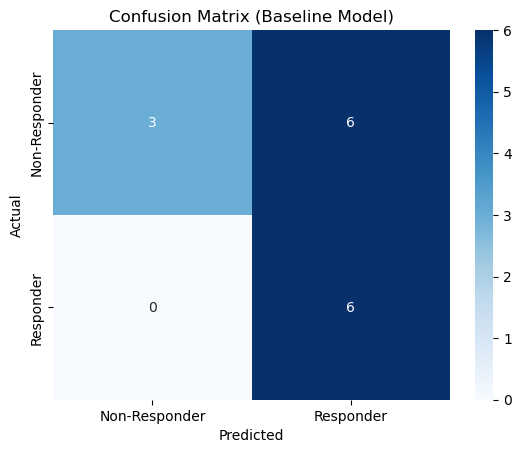

In [22]:
# Flatten the padded arrays
X_baseline = np.array([pat.DMDbefore.flatten() for pat in patients_resp])  # Flattened EEG data
y_baseline = np.array([pat.response for pat in patients_resp])  # Treatment response as target

# Split the data into training and testing sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_baseline, y_baseline, test_size=0.3, random_state=42)

# Train a baseline classifier
clf_baseline = RandomForestClassifier(random_state=42)
clf_baseline.fit(X_train_base, y_train_base)

# Make predictions
y_pred_base = clf_baseline.predict(X_test_base)

# Evaluate the baseline model
accuracy = accuracy_score(y_test, y_pred)
accuracy_base = accuracy_score(y_test_base, y_pred_base)
print(f"Baseline Model Accuracy (Without Clusters): {accuracy_base:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test_base, y_pred_base))
dmd_pred = y_pred_base
dmd_test = y_test_base

# Confusion Matrix for Baseline Model
conf_matrix_base = confusion_matrix(y_test_base, y_pred_base)
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Responder', 'Responder'], yticklabels=['Non-Responder', 'Responder'])
plt.title('Confusion Matrix (Baseline Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Comparison of the models

In [23]:
print("\nOnly Clusters Report:\n", classification_report(clus_test, clus_pred))
print("\nOnly DMD Arrays Report:\n", classification_report(dmd_test, dmd_pred))
print("\nBoth Clusters and DMD Arrays Report:\n", classification_report(clus_dmd_test, clus_dmd_pred))


Only Clusters Report:
               precision    recall  f1-score   support

       False       1.00      0.44      0.62         9
        True       0.55      1.00      0.71         6

    accuracy                           0.67        15
   macro avg       0.77      0.72      0.66        15
weighted avg       0.82      0.67      0.65        15


Only DMD Arrays Report:
               precision    recall  f1-score   support

       False       1.00      0.33      0.50         9
        True       0.50      1.00      0.67         6

    accuracy                           0.60        15
   macro avg       0.75      0.67      0.58        15
weighted avg       0.80      0.60      0.57        15


Both Clusters and DMD Arrays Report:
               precision    recall  f1-score   support

       False       1.00      0.33      0.50         9
        True       0.50      1.00      0.67         6

    accuracy                           0.60        15
   macro avg       0.75      0.67      

## 9. Export Cluster Assignments
Export the patient cluster assignments for use in further analyses.

In [24]:
# Create a ndarray of the patients with two columns: name and cluster
patients_clusters = np.array([[pat.name, pat.cluster] for pat in patients_resp])
# Export the patients_clusters to a CSV file
np.savetxt('../output/patients_clusters.csv', patients_clusters, delimiter=',', fmt='%s', header='Patient, Cluster')

## 10. Analyze Depression Types by Cluster
Summarize the distribution of depression types within each cluster.

In [25]:
depression_types = {
    'Melancholic': 0,
    'Atypical': 0,
    'Neither Melancholic, Atypical, Nor catatonic': 0,
}
dep_type_by_cluster = [depression_types.copy() for i in range(3)]
for pat in patients:
    dep_type_by_cluster[pat.cluster][pat.depression_type] += 1
# Create a DataFrame for visualization
clusters_df = pd.DataFrame(columns=[' ', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
types = ['Melancholic', 'Atypical', 'Neither Melancholic, Atypical, Nor catatonic']
for i, dep_type in enumerate(types):
    clusters_df.loc[i] = [dep_type, dep_type_by_cluster[0][dep_type], dep_type_by_cluster[1][dep_type], dep_type_by_cluster[2][dep_type]]
clusters_df.set_index(' ', inplace=True)
clusters_df = clusters_df.T
clusters_df

,Melancholic,Atypical,"Neither Melancholic, Atypical, Nor catatonic"
Cluster 1,14,7,5
Cluster 2,7,5,2
Cluster 3,4,4,4


---

**Summary:**
This notebook provides a reproducible pipeline for clustering patients based on EEG DMD features and evaluating the relationship between clusters and clinical outcomes. The workflow includes dimensionality reduction, clustering, visualization, predictive modeling, and clinical interpretation.